# How to extract a file

In [21]:
# !apt install unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [22]:
# !unzip -q "/content/data.zip"

unzip:  cannot find or open /content/data.zip, /content/data.zip.zip or /content/data.zip.ZIP.


# Download github files & datasets

uncomment the following code to download the files
(remove the `#` for download data sets)

In [23]:
!apt install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [24]:
!git clone "https://github.com/rezapace/Machine-Learning-Sound-Detection"

fatal: destination path 'Machine-Learning-Sound-Detection' already exists and is not an empty directory.


# Running the Sound Detection Program

In [4]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from IPython import display

In [5]:
# Set the seed value for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Path to the dataset
DATASET_PATH = '/content/Machine-Learning-Sound-Detection/data'

data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['firetruck' 'ambulance' 'traffic']


In [6]:
# Load dataset
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    return tf.squeeze(audio, axis=-1)

def get_waveform_and_label(file_path):
    label = tf.strings.split(file_path, os.path.sep)[-2]
    label = tf.argmax(label == commands)  # Convert label to integer
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

def get_dataset(data_dir):
    files = tf.data.Dataset.list_files(str(data_dir/'*/*'))
    output_ds = files.map(get_waveform_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    return output_ds

In [7]:
# Split dataset into training, validation, and test sets
full_ds = get_dataset(data_dir)
full_ds = full_ds.shuffle(buffer_size=10000, seed=seed, reshuffle_each_iteration=False)
full_ds_size = len(list(full_ds))

train_size = int(0.8 * full_ds_size)
val_size = int(0.1 * full_ds_size)
test_size = full_ds_size - train_size - val_size

train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size).take(val_size)
test_ds = full_ds.skip(train_size + val_size)

print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

Train size: 480, Validation size: 60, Test size: 61


In [8]:
# Preprocess dataset
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.image.resize(spectrogram[..., tf.newaxis], [1032, 129])  # Resize to expected shape
    return spectrogram

def make_spec_ds(ds):
    return ds.map(lambda audio, label: (get_spectrogram(audio), label), num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [9]:
# Add a dimension to the input spectrogram
def add_batch_dimension(spectrogram, label):
    spectrogram = tf.expand_dims(spectrogram, -1)  # Add channel dimension
    return spectrogram, label

train_spectrogram_ds = train_spectrogram_ds.map(add_batch_dimension)
val_spectrogram_ds = val_spectrogram_ds.map(add_batch_dimension)
test_spectrogram_ds = test_spectrogram_ds.map(add_batch_dimension)

In [10]:
# Cache, shuffle, and prefetch the datasets
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [11]:
# Build the model
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    input_shape = example_spectrograms.shape[1:]

num_labels = len(commands)

model = models.Sequential([
    layers.Input(shape=(input_shape[0], input_shape[1], 1)),  # Add channel dimension
    layers.Resizing(32, 32),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                        

In [12]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [13]:
# Check the number of elements in the dataset
print(f"Number of elements in train dataset: {len(list(train_spectrogram_ds))}")
print(f"Number of elements in validation dataset: {len(list(val_spectrogram_ds))}")
print(f"Number of elements in test dataset: {len(list(test_spectrogram_ds))}")

Number of elements in train dataset: 15
Number of elements in validation dataset: 2
Number of elements in test dataset: 2


In [14]:
# Path to the dataset
DATASET_PATH = '/content/Machine-Learning-Sound-Detection/data'
data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['firetruck' 'ambulance' 'traffic']


In [15]:
# Train the model
EPOCHS = 100
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/100
15/15 [==============================] - 3s 151ms/step - loss: 0.8050 - accuracy: 0.6167 - val_loss: 0.5473 - val_accuracy: 0.8833
Epoch 2/100
15/15 [==============================] - 2s 121ms/step - loss: 0.4108 - accuracy: 0.8708 - val_loss: 0.2526 - val_accuracy: 0.9000
Epoch 3/100
15/15 [==============================] - 4s 271ms/step - loss: 0.2833 - accuracy: 0.8938 - val_loss: 0.1895 - val_accuracy: 0.9333
Epoch 4/100
15/15 [==============================] - 3s 197ms/step - loss: 0.2460 - accuracy: 0.9062 - val_loss: 0.1798 - val_accuracy: 0.9500
Epoch 5/100
15/15 [==============================] - 2s 142ms/step - loss: 0.2297 - accuracy: 0.9333 - val_loss: 0.1563 - val_accuracy: 0.9333
Epoch 6/100
15/15 [==============================] - 3s 181ms/step - loss: 0.1716 - accuracy: 0.9354 - val_loss: 0.1609 - val_accuracy: 0.9333
Epoch 7/100
15/15 [==============================] - 3s 185ms/step - loss: 0.1607 - accuracy: 0.9458 - val_loss: 0.1501 - val_accuracy: 0.9500

Text(0, 0.5, 'Accuracy [%]')

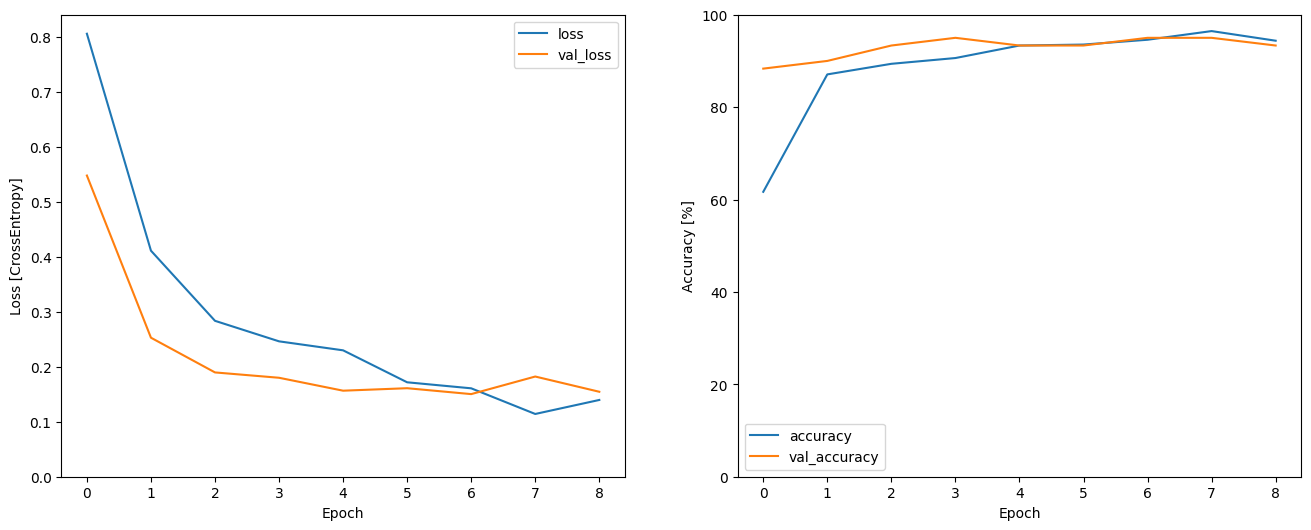

In [16]:
# Evaluate the model
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [17]:
# Evaluate on test set
model.evaluate(test_spectrogram_ds, return_dict=True)

2/2 [==============================] - 0s 29ms/step - loss: 0.0653 - accuracy: 0.9836


{'loss': 0.06534239649772644, 'accuracy': 0.9836065769195557}

In [18]:
from sklearn.metrics import classification_report

# Prediksi pada data validasi atau test
y_true = []  # Label asli
y_pred = []  # Prediksi model

for spectrograms, labels in test_spectrogram_ds:
    predictions = model.predict(spectrograms)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())

print(classification_report(y_true, y_pred, target_names=commands))

1/1 [==============================] - 0s 108ms/step
              precision    recall  f1-score   support

   firetruck       1.00      0.95      0.98        21
   ambulance       1.00      1.00      1.00        21
     traffic       0.95      1.00      0.97        19

    accuracy                           0.98        61
   macro avg       0.98      0.98      0.98        61
weighted avg       0.98      0.98      0.98        61



In [19]:
# Predict on new audio
def predict(model, file_path):
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    spectrogram = get_spectrogram(waveform)
    spectrogram = tf.expand_dims(spectrogram, -1)  # Add channel dimension
    spectrogram = spectrogram[tf.newaxis, ...]  # Add batch dimension
    prediction = model(spectrogram)
    predicted_label = tf.argmax(prediction, axis=1)
    return commands[predicted_label.numpy()[0]]

# Test from existing directory files

In [23]:
# Minta pengguna untuk memasukkan lokasi file audio
file_path = input("Masukkan lokasi file audio: ")

# Prediksi label dari file audio yang diberikan
predicted_label = predict(model, file_path)
print(f'Predicted label: {predicted_label}')

Masukkan lokasi file audio: /content/bunyi_sirine_pemadam_kebakaran_Ac7IVsW8Wvg_140.wav
Predicted label: ambulance


# Test With Youtube Link

In [20]:
!pip install pytube pydub
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [21]:
from pytube import YouTube
from pydub import AudioSegment
import os
import numpy as np
import tensorflow as tf

# Function to download video from YouTube
def download_video_from_youtube(youtube_url, output_path='video.mp4'):
    yt = YouTube(youtube_url)
    video_stream = yt.streams.filter(only_audio=True).first()
    video_stream.download(filename=output_path)
    return output_path

# Function to convert MP4 to WAV
def convert_mp4_to_wav(mp4_path):
    try:
        audio = AudioSegment.from_file(mp4_path, format="mp4")
        wav_path = mp4_path.replace('.mp4', '.wav')
        audio.export(wav_path, format='wav')
        return wav_path
    except Exception as e:
        print(f"Error converting MP4 to WAV: {e}")
        return None

# Main function to download and convert YouTube video to WAV
def youtube_to_wav(youtube_url, output_dir='/content'):
    mp4_path = os.path.join(output_dir, 'video.mp4')
    wav_path = os.path.join(output_dir, 'audio.wav')

    # Download video from YouTube
    download_video_from_youtube(youtube_url, mp4_path)

    # Convert MP4 to WAV
    wav_path = convert_mp4_to_wav(mp4_path)

    if wav_path:
        print(f'Audio saved to: {wav_path}')
    else:
        print('Failed to convert audio to WAV.')

    return wav_path

# Function to decode audio
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    return tf.squeeze(audio, axis=-1)

# Function to get spectrogram
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.image.resize(spectrogram[..., tf.newaxis], [1032, 129])  # Resize to expected shape
    return spectrogram

# Function to process and predict audio
def predict_audio(model, commands, filename):
    # Process audio
    audio_binary = tf.io.read_file(filename)
    waveform = decode_audio(audio_binary)
    spectrogram = get_spectrogram(waveform)
    spectrogram = tf.expand_dims(spectrogram, -1)  # Add channel dimensions
    spectrogram = spectrogram[tf.newaxis, ...]  # Add batch dimensions

    # Prediction using the model
    prediction = model(spectrogram)
    predicted_label = tf.argmax(prediction, axis=1)
    return commands[predicted_label.numpy()[0]]

# Prompt user for YouTube URL
youtube_url = input('Please enter the YouTube video URL: ')

# Convert YouTube video to WAV
wav_path = youtube_to_wav(youtube_url)

# Usage example
commands = np.array(['firetruck', 'ambulance', 'traffic'])  # Replace with appropriate label

# Predict the label of the converted audio file
predicted_label = predict_audio(model, commands, wav_path)
print(f'Predicted label: {predicted_label}')

Please enter the YouTube video URL: https://youtube.com/shorts/T8T3bF2CcPQ?si=mGU8EoWdCnHPSBAy
Audio saved to: /content/video.wav
Predicted label: ambulance


# Testing with file upload

In [22]:
from google.colab import files
import tensorflow as tf
import numpy as np
from pydub import AudioSegment

# Function to upload files
def upload_audio():
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f'User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')
    return list(uploaded.keys())[0]

# Function to convert MP3 to WAV
def convert_mp3_to_wav(mp3_path):
    audio = AudioSegment.from_mp3(mp3_path)
    wav_path = mp3_path.replace('.mp3', '.wav')
    audio.export(wav_path, format='wav')
    return wav_path

# Function to process and predict audio
def predict_uploaded_audio(model, commands, filename):
    # Convert MP3 to WAV if necessary
    if filename.endswith('.mp3'):
        filename = convert_mp3_to_wav(filename)

    # Process uploaded audio
    audio_binary = tf.io.read_file(filename)
    waveform = decode_audio(audio_binary)
    spectrogram = get_spectrogram(waveform)
    spectrogram = tf.expand_dims(spectrogram, -1)  # Add channel dimensions
    spectrogram = spectrogram[tf.newaxis, ...]  # Add batch dimensions

    # Prediction using the model
    prediction = model(spectrogram)
    predicted_label = tf.argmax(prediction, axis=1)
    return commands[predicted_label.numpy()[0]]

# Usage example
commands = np.array(['firetruck', 'ambulance', 'traffic'])  # Replace with appropriate label

# Upload audio files
filename = upload_audio()

# Predict the label of the uploaded audio file
predicted_label = predict_uploaded_audio(model, commands, filename)
print(f'Predicted label: {predicted_label}')

Saving FDNY_ambulance_responding_in_New_York_emergencyvehicles_T8T3bF2CcPQ.mp3 to FDNY_ambulance_responding_in_New_York_emergencyvehicles_T8T3bF2CcPQ.mp3
User uploaded file "FDNY_ambulance_responding_in_New_York_emergencyvehicles_T8T3bF2CcPQ.mp3" with length 806668 bytes
Predicted label: ambulance


# Testing live

In [24]:
!pip install pydub
!pip install ffmpeg-python
!pip install ffmpeg-python pydub

In [25]:
from IPython.display import Javascript, display
from google.colab import output
from base64 import b64decode
from io import BytesIO
from pydub import AudioSegment
import ffmpeg
from google.colab import output
import io
import ffmpeg
from pydub import AudioSegment
from base64 import b64decode
from IPython.display import Javascript, display
import tensorflow as tf
import numpy as np

In [27]:
# Set the seed value for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# JavaScript untuk merekam audio
RECORD_JS = """
const sleep = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = () => resolve(reader.result)
  reader.readAsDataURL(blob)
})

var record = time => new Promise(resolve => {
  navigator.mediaDevices.getUserMedia({ audio: true }).then(stream => {
    const mediaRecorder = new MediaRecorder(stream)
    let chunks = []
    mediaRecorder.ondataavailable = e => chunks.push(e.data)
    mediaRecorder.start()
    sleep(time).then(() => {
      mediaRecorder.onstop = async () => {
        let blob = new Blob(chunks)
        let text = await b2text(blob)
        resolve(text)
      }
      mediaRecorder.stop()
    })
  })
})
"""

def fix_riff_header(binary):
    process = (ffmpeg
        .input('pipe:0')
        .output('pipe:1', format='wav')
        .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
    )
    output, _ = process.communicate(input=binary)
    return output

def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    return tf.squeeze(audio, axis=-1)

def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.image.resize(spectrogram[..., tf.newaxis], [1032, 129])  # Resize to expected shape
    return spectrogram

def record(sec=3):
    display(Javascript(RECORD_JS))
    print("Recording...")
    s = output.eval_js('record(%d)' % (sec * 1000))
    b = b64decode(s.split(',')[1])
    b = fix_riff_header(b)
    with open('audio.wav', 'wb') as f:
        f.write(b)
    audio = AudioSegment.from_wav('audio.wav')
    return audio

def predict_uploaded_audio(model, commands, filename):
    #  Process uploaded audio
    audio_binary = tf.io.read_file(filename)
    waveform = decode_audio(audio_binary)
    spectrogram = get_spectrogram(waveform)
    spectrogram = tf.expand_dims(spectrogram, -1)  # Add channel dimensions
    spectrogram = spectrogram[tf.newaxis, ...]  # Add batch dimensions

    # Prediction using the model
    prediction = model(spectrogram)
    predicted_label = tf.argmax(prediction, axis=1)
    return commands[predicted_label.numpy()[0]]

# Usage example
commands = np.array(['firetruck', 'ambulance', 'traffic'])  # Replace with appropriate label

# Record audio for 15 seconds
audio = record(15)
audio.export("recorded_audio.wav", format="wav")

# Predict the label of the uploaded audio file
predicted_label = predict_uploaded_audio(model, commands, "recorded_audio.wav")
print(f'Predicted label: {predicted_label}')

# Play back the recorded audio
import IPython.display as ipd
ipd.Audio("recorded_audio.wav")

<IPython.core.display.Javascript object>

Recording...
Predicted label: ambulance


# Convert youtube to dataset

In [32]:
from pytube import YouTube
from pydub import AudioSegment
import os

# Fungsi untuk mengunduh video YouTube dan mengonversinya ke format WAV
def youtube_to_wav(youtube_url, output_dir='/content/Machine-Learning-Sound-Detection'):
    # Buat direktori jika belum ada
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Unduh video dari YouTube
    yt = YouTube(youtube_url)
    video = yt.streams.filter(only_audio=True).first()
    out_file = video.download(output_path=output_dir, filename='temp.mp4')

    # Tentukan nama file output yang berurutan
    existing_files = os.listdir(output_dir)
    wav_files = [f for f in existing_files if f.endswith('.wav')]
    next_index = len(wav_files) + 1
    wav_file = os.path.join(output_dir, f'audio_{next_index}.wav')

    # Konversi MP4 ke WAV
    audio = AudioSegment.from_file(out_file, format="mp4")
    audio.export(wav_file, format="wav")

    # Hapus file MP4 sementara
    os.remove(out_file)

    print(f'File WAV disimpan di: {wav_file}')
    return wav_file

# Contoh penggunaan
youtube_url = input("Masukkan URL YouTube: ")
output_wav = youtube_to_wav(youtube_url)

Masukkan URL YouTube: https://youtube.com/shorts/T8T3bF2CcPQ?si=mGU8EoWdCnHPSBAy
File WAV disimpan di: /content/Machine-Learning-Sound-Detection/audio_2.wav


We hope this README provides a clear and engaging overview of the Machine Learning Detection Sound project. Join us in advancing the field of audio-based machine learning for automotive applications!

Regards,**Reza Hidayat** 👩🏻‍💻